In [2]:
library("ggpubr")
library("tidyverse")
library(parallel)
library(lmerTest)
library(lme4)
suppressPackageStartupMessages(library(performance))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(ggrepel))
library(RColorBrewer)
library(viridis)

Loading required package: ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


Loading required package: viridisLite



In [3]:
Olnik<-read.csv('Olink.csv')

In [18]:
meta<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta<-meta %>% filter(sample.visitName %in% c('Flu Year 1 Day 0'))

In [29]:
prop.table(table(meta$cohort.cohortGuid,meta$subject.biologicalSex))

     
         Female      Male
  BR1 0.2826087 0.2282609
  BR2 0.2717391 0.2173913

In [4]:
meta<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta<-meta %>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 2 Day 0'))

In [5]:
rownames(meta)<-meta$sample.sampleKitGuid

In [6]:
n_distinct(meta$subject.subjectGuid)


[1] 92

In [7]:
Olnik<-Olnik %>% filter(sample.sampleKitGuid %in% unique(meta$sample.sampleKitGuid))

In [8]:
Olnik<-left_join(Olnik,meta, by = c("sample.sampleKitGuid"))

In [9]:
Olnik_filtered<-Olnik
df_olink_filtering<- as.data.frame(table(Olnik_filtered$batch,Olnik_filtered$Assay)) %>% filter(Freq==0)
Olnik_filtered<-Olnik_filtered %>% filter(!Assay %in% names(table(df_olink_filtering$Var2)[table(df_olink_filtering$Var2)==5]))
res_list<-mclapply(unique(Olnik_filtered$Assay),function(x){
Olnik_sub<-Olnik_filtered  %>% filter(sample.visitName%in% c('Flu Year 1 Day 0','Flu Year 2 Day 0'),Assay==x)
res<-lmer(NPX_bridged ~ sample.visitName+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex+cohort.cohortGuid+(1|subject.subjectGuid), data=Olnik_sub)
res<-as.data.frame(summary(res)$coefficients)[2:5,]
res$factor<-c('Visit','CMV','Sex','Age')  
res$Assay<-x
res$Log2FC_Age<-Olnik_sub %>%
  dplyr::group_by(Assay, sample.visitName) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(sample.visitName, Mean_Expression) %>%
  mutate(Log2FC = log2(`Flu Year 1 Day 0` / `Flu Year 2 Day 0`))%>% ungroup() %>% select(Log2FC) %>% pull()
res$diff<-Olnik_sub %>%
  dplyr::group_by(Assay, sample.visitName) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(sample.visitName, Mean_Expression) %>%
  mutate(diff = `Flu Year 1 Day 0`- `Flu Year 2 Day 0`)%>% select(diff) %>% pull()    
return(res)
},mc.cores=60)

In [10]:
res_all<-do.call(rbind,res_list)

In [11]:
res_all_Visit<-res_all %>% filter(factor=='Visit')

In [12]:
res_all_Visit$padj<-p.adjust(res_all_Visit$`Pr(>|t|)`)


In [13]:
data <- res_all_Visit%>% mutate(Expression = case_when(diff >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     diff <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [14]:
top <- 30
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top))

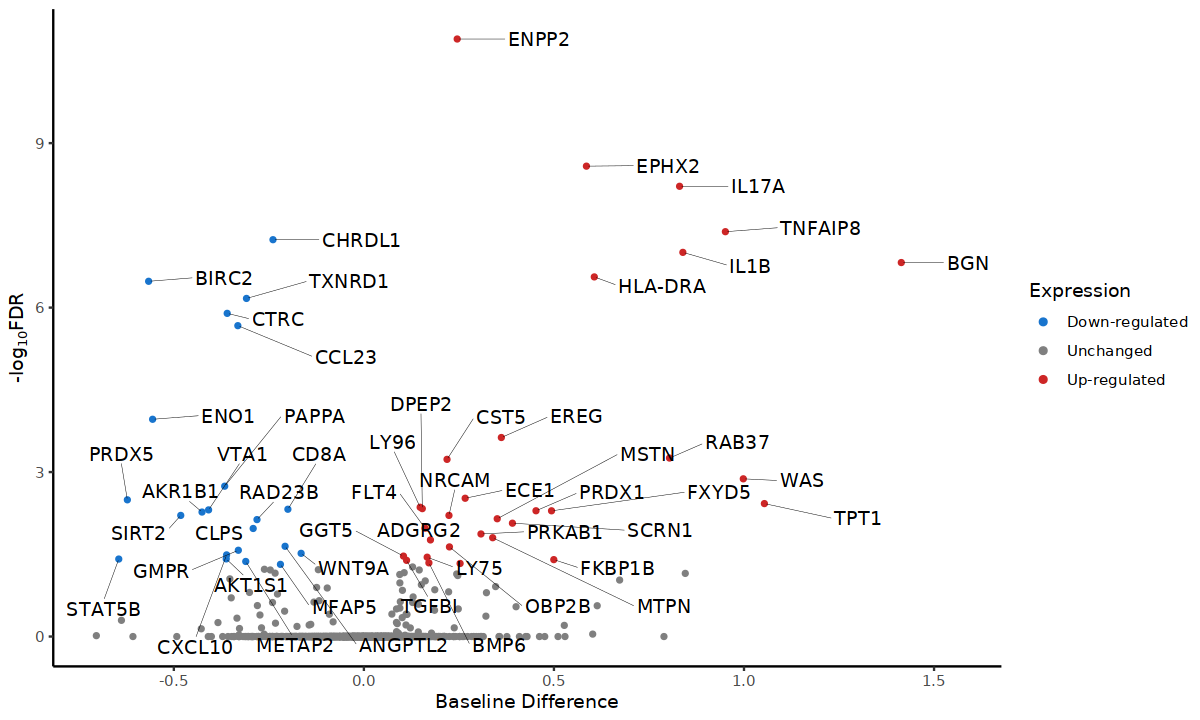

In [15]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(data, aes(diff, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 1) +
  xlab(expression("Baseline Difference")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=50,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(diff, -log(padj,10), label = Assay),
                   size = 4)+theme_classic()


In [16]:
write.csv(data %>% arrange(padj),'Olink_Y1_Y2.csv')